In [13]:
import pandas as pd
from networkx.drawing.nx_pydot import write_dot
import networkx as nx
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re

In [14]:
out_folder = 'output/results/'

associated_variables = pd.read_csv('input/associated_variables.csv', sep='\t')
relation_overview = pd.read_csv('input/relation_overview.csv', sep='\t')

In [15]:
associations = list(associated_variables.columns[2:])
associations = [i for i in associations if not i.startswith('Unnamed')]
result = {}
relations_for_total = ['1', '2', '3']

for association in associations:

    sub_df = associated_variables[associated_variables[association] == True][['Variable', 'ID']]
    # association_ids = set(sub_df['ID'].to_list())
    association_variables = set(sub_df['Variable'].to_list())

    # print(f'Association: {association}:\n\t{"\n\t".join(association_variables)}')

    for other_association in associations:
        tag = f'{association} -> {other_association}'
        if other_association == association:
            continue

        other_sub_df = associated_variables[associated_variables[other_association] == True][['Variable', 'ID']]
        other_association_variables = set(other_sub_df['Variable'].to_list())


        if len(other_association_variables) != len(other_association_variables - association_variables):
            print(tag)
            print(other_association_variables, association_variables, other_association_variables - association_variables)

        relations_a = relation_overview[(relation_overview['Variable A'].isin(association_variables)) & (relation_overview['Variable B'].isin(other_association_variables))]['Group (base)'].to_list()
        relations_b = relation_overview[(relation_overview['Variable A'].isin(other_association_variables)) & (relation_overview['Variable B'].isin(association_variables))]['Group (base)'].to_list()

        result[tag] = {
            'total': len([relation for relation in relations_a + relations_b if relation in relations_for_total])
        }

        for relation in relations_a + relations_b:
            if relation not in result[tag]:
                result[tag][relation] = 1
            else:
                result[tag][relation] += 1
            


In [16]:
print(result)

{'Issue management (basic) -> Issue management (advanced)': {'total': 6, '31': 12, '3': 1, '2': 2, '32': 1, '1': 3}, 'Issue management (basic) -> Issue management roles': {'total': 9, '31': 16, '32': 5, '1': 8, '3': 1}, 'Issue management (basic) -> Discussion aspects (action)': {'total': 10, '31': 19, '1': 10, 'E': 1}, 'Issue management (basic) -> Discussion aspects (target)': {'total': 10, '31': 19, '3': 1, '1': 9, 'E': 1}, 'Issue management (basic) -> Discussion aspects (topic)': {'total': 10, '31': 19, '2': 1, '1': 7, '3': 2, 'E': 1}, 'Issue management (basic) -> Discussion frequency': {'total': 6, '31': 14, 'E': 19, '32': 11, '3': 5, '2': 1}, 'Issue management (basic) -> Discussant roles': {'total': 8, '31': 20, 'E': 2, '1': 8}, 'Issue management (basic) -> Discussion tools': {'total': 5, '31': 4, '32': 1, '1': 3, '3': 2}, 'Issue management (basic) -> Review scope': {'total': 6, '31': 4, '1': 6}, 'Issue management (basic) -> Commit type': {'total': 21, '31': 14, '32': 15, '3': 6, '

In [17]:
result['Refactorings -> Discussion tools']

{'total': 2, '3': 1, '31': 2, '1': 1}

In [18]:
def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=6000, node_color='white', edgecolors='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(
        G, pos, connectionstyle=connectionstyle, 
        edge_color=[attrs['edge_color'] for u, v, key, attrs in G.edges(keys=True, data=True)],
        width=[attrs['edge_width'] for u, v, key, attrs in G.edges(keys=True, data=True)],
        alpha=0.7,
        ax=ax)

    labels = {
        tuple(edge): attrs[attr_name]
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        ax=ax,
    )

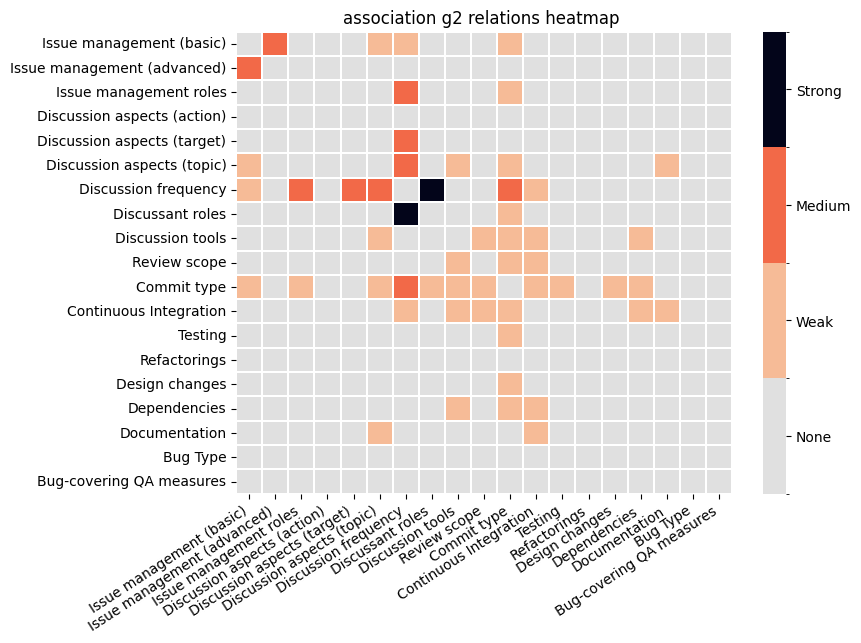

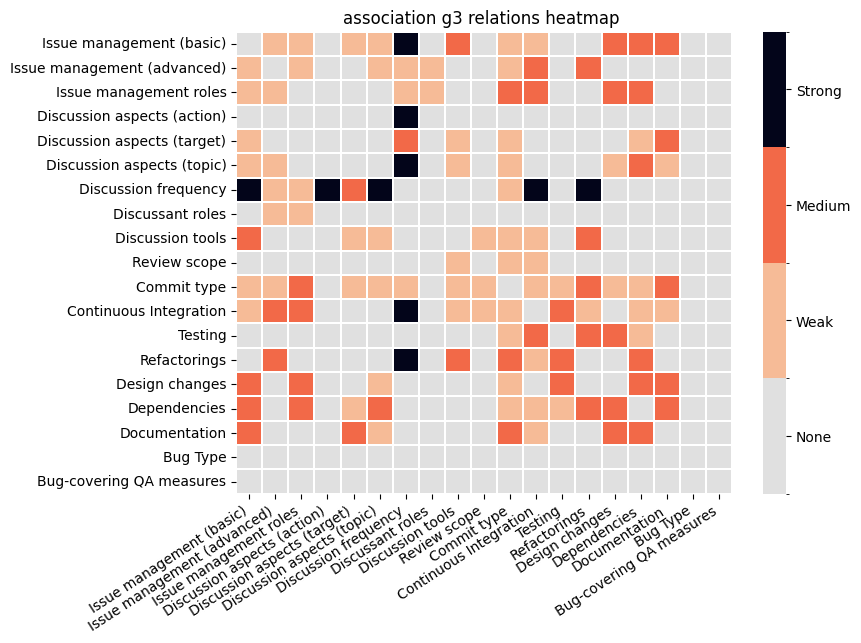

In [ ]:
import seaborn as sns

# Initialize dictionaries to store counts for G2 and G3 relations
g2_counts = {association: {other_association: 0 for other_association in associations} for association in associations}
g3_counts = {association: {other_association: 0 for other_association in associations} for association in associations}

# Populate the dictionaries with counts from the result
for key, value in result.items():
    association_a, association_b = key.split(' -> ')
    if '2' in value:
        g2_counts[association_a][association_b] = value['2'] / value['total']
    if '3' in value:
        g3_counts[association_a][association_b] = value['3'] / value['total']

# Convert dictionaries to DataFrames
g2_df = pd.DataFrame(g2_counts)
g3_df = pd.DataFrame(g3_counts)

def draw_heatmap(heatmap_df, out_file, only_rows=None):

    cmap = mcolors.ListedColormap(['#eeeeee', '#f6bb97', '#f26948', '#03051a'])
    max_value = heatmap_df.max().max()
    bounds = [0, 0.000000001, max_value * 0.33, max_value * 0.66, max_value]
    labels = ['None', 'Weak', 'Medium', 'Strong']
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    height = 6
    if only_rows:
        heatmap_df = heatmap_df.loc[only_rows]
        height = 1 + len(only_rows) * 0.25

    fig = plt.figure(figsize=(8, height))
    ax = sns.heatmap(heatmap_df, annot=False, cmap=cmap, norm=norm, linewidths=0.01, linecolor='white')

    colorbar = ax.collections[0].colorbar 
    r = (colorbar.vmax - colorbar.vmin) / len(labels)
    colorbar.set_ticks([start + (end - start)/2 for (start, end) in zip(bounds[:-1], bounds[1:])])
    colorbar.set_ticklabels(labels)

    plt.xticks(rotation=33, ha='right')
    plt.savefig(out_folder + out_file, bbox_inches='tight')
    plt.title(re.sub(r'[_]', ' ', out_file.replace('.pdf', ' ')))
    plt.show()

draw_heatmap(g2_df, 'association_g2_relations_heatmap.pdf')
draw_heatmap(g3_df, 'association_g3_relations_heatmap.pdf')


In [20]:
latex = f'We created {len(associations)} logical groups:\n\\begin{{itemize}}\n'

for association in associations:
    latex += f'\t\\item {association}\n'

latex += '\\end{itemize}\n'

print(latex)

We created 19 logical groups:
\begin{itemize}
	\item Issue management (basic)
	\item Issue management (advanced)
	\item Issue management roles
	\item Discussion aspects (action)
	\item Discussion aspects (target)
	\item Discussion aspects (topic)
	\item Discussion frequency
	\item Discussant roles
	\item Discussion tools
	\item Review scope
	\item Commit type
	\item Continuous Integration
	\item Testing
	\item Refactorings
	\item Design changes
	\item Dependencies
	\item Documentation
	\item Bug Type
	\item Bug-covering QA measures
\end{itemize}



In [21]:
associations_tbl = associated_variables[['ID'] + associations]
associations_tbl = associations_tbl.rename(columns={association: '\\rot{' + association + '}' for association in associations})
associations_tbl = associations_tbl.fillna('~').replace(True, 'X')

# Insert a midbar every time the leading letters in ID change
midrule_indices = []
previous_leading_letters = None
for index, row in associations_tbl.iterrows():
    leading_letters = re.match(r'^[A-Za-z]{1,2}', row['ID']).group(0)
    if previous_leading_letters and previous_leading_letters != leading_letters:
        midrule_indices.append(index)
    previous_leading_letters = leading_letters

# Sort the dataframe to ensure the midrules are in the correct place
associations_tbl = associations_tbl.sort_index().reset_index(drop=True)

latex = associations_tbl.to_latex(index=False, column_format='l|' + 'c' * len(associations), longtable=True, label='tbl-appendix:logically-associated-variables', caption='Groups of logically associated variables.')
latex_list = latex.splitlines()
content_start = latex_list.index('\\endlastfoot') + 1

for index in reversed(midrule_indices):
    latex_list.insert(content_start + index, '\\midrule')

latex = '\n'.join(latex_list)
with open(out_folder + 'associations.tex', 'w') as f:
    f.write(latex)

### Impact on Related Work

#### Querel et al.

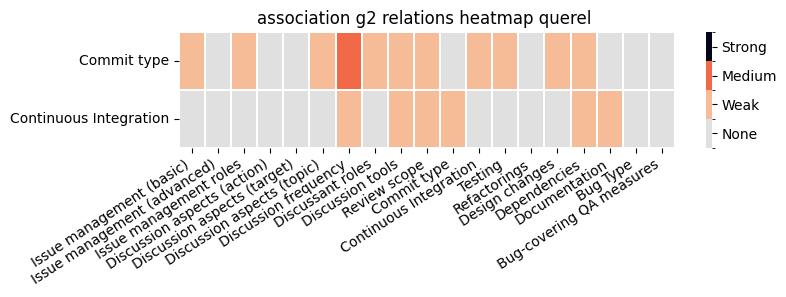

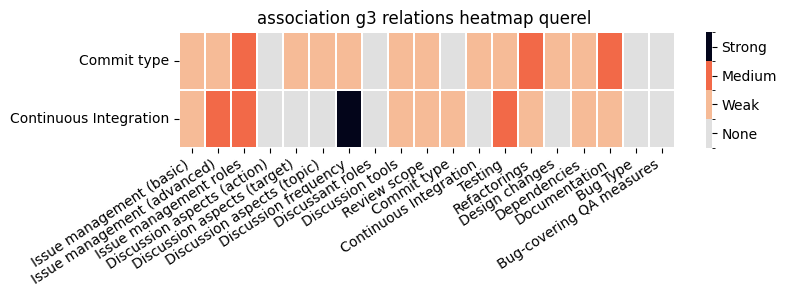

In [22]:
only_rows = ['Commit type', 'Continuous Integration']


draw_heatmap(g2_df, 'association_g2_relations_heatmap_querel.pdf', only_rows)
draw_heatmap(g3_df, 'association_g3_relations_heatmap_querel.pdf', only_rows)

#### Ghafari et al.

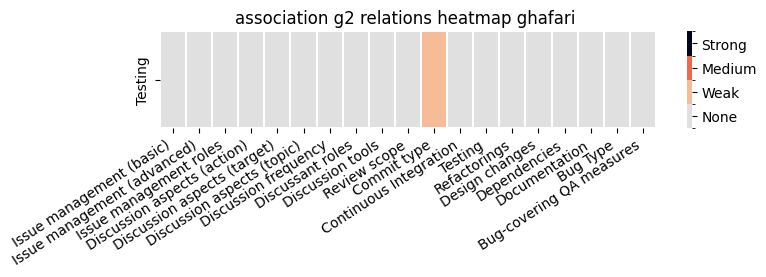

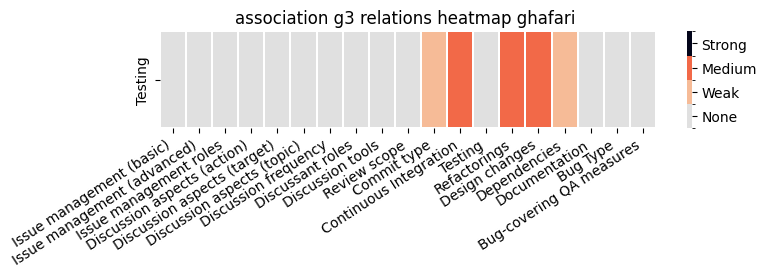

In [23]:
only_rows = ['Testing']


draw_heatmap(g2_df, 'association_g2_relations_heatmap_ghafari.pdf', only_rows)
draw_heatmap(g3_df, 'association_g3_relations_heatmap_ghafari.pdf', only_rows)

#### Kononenko et al.

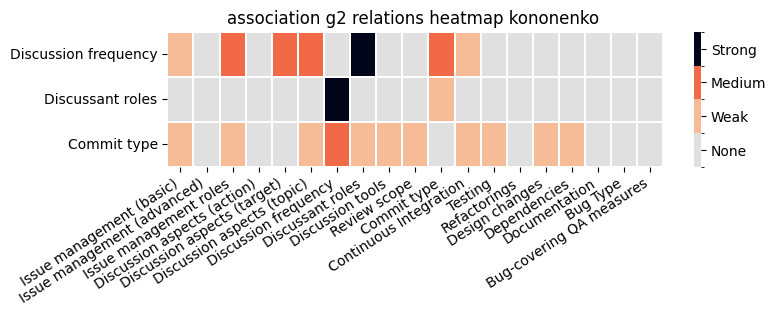

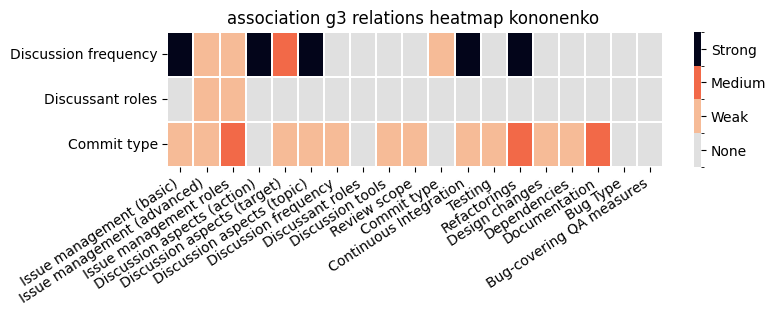

In [24]:
only_rows = ['Discussion frequency', 'Discussant roles', 'Commit type']


draw_heatmap(g2_df, 'association_g2_relations_heatmap_kononenko.pdf', only_rows)
draw_heatmap(g3_df, 'association_g3_relations_heatmap_kononenko.pdf', only_rows)